# OLS vs. Lasso

This notebook presents a simple implementation of Lasso (and elastic net) regressions. It uses the [Convex.jl](https://github.com/jump-dev/Convex.jl) and [SCS.jl](https://github.com/jump-dev/SCS.jl) packages.

## Load Packages and Extra Functions

In [1]:
using Dates, DelimitedFiles, LinearAlgebra, Statistics, Convex, SCS

import MathOptInterface
const MOI = MathOptInterface

include("jlFiles/printmat.jl")

printwhere (generic function with 1 method)

In [2]:
using Plots, LaTeXStrings

#pyplot(size=(600,400))           #pyplot or gr
gr(size=(480,320))
default(fmt = :svg)

# Loading Data

In [3]:
(x,header) = readdlm("Data/Fin1PerfEvalEmp.csv",',',header=true)

(IndNames,FundNames) = (header[2:9],header[10:11])     #names of variables

dN             = Date.(x[:,1],"yyyy-mm-dd")       #convert to Date
(Rb,RFunds,Rf) = (convert.(Float64,x[:,2:9]),convert.(Float64,x[:,10:11]),
                  convert.(Float64,x[:,12]));     #convert to Float64

# Lasso Regression

using the Convex and SCS packages.


Notice:  
(a)  The regression is $Y = Xb + u$, 
where $Y$ and $u$ are $T \times 1$, $X$ is $T \times K$, and $b$ is the $K$-vector of regression coefficients.
               
(b) Write the sum of squared residuals of the regression as   

$(Y-Xb)'(Y-Xb) = Y'Y - 2Y'Xb + b'X'Xb$. 

Only the two last terms matter for the choice of $b$. 
                             
(c) To minimize $b'X'Xb - 2Y'Xb + \gamma \sum |b_i|$, we use the Convex package. To speed up the iteration we calculate $X'Y$ and $X'X$ only once.

Notice, we could equally well minimize $(Y-Xb)'(Y-Xb)$, but that is slower since we have re-evaluate the whole expression (including $Y'Y$ and $X'X$) in each iteration.

In [4]:
"""
    LassoEN(Y,X,γ,λ)

Do Lasso (set γ>0,λ=0), ridge (set γ=0,λ>0) or elastic net regression (set γ>0,λ>0). 

"""
function LassoEN(Y,X,γ,λ=0.0)
    
    K = size(X,2)

    b_ls = X\Y                    #LS estimate of weights, no restrictions

    Q  = X'X
    c  = X'Y                      #c'b = Y'X*b
    
    b  = Variable(K)              #define variables to optimize over           
    L1 = quadform(b,Q)            #b'Q*b
    L2 = dot(c,b)                 #c'b
    L3 = norm(b,1)                #sum(|b|)
    L4 = norm(b,2)                #sum(b^2)
  
    Sol = minimize(L1-2*L2+γ*L3+λ*L4)      #0.5*u'u/T + γ*sum(|b|) + λsum(b^2), where u = Y-Xb
    solve!(Sol,()->SCS.Optimizer(verbose = false))
    Sol.status == MOI.OPTIMAL ? b_i = vec(evaluate(b)) : b_i = NaN
    
    return b_i,b_ls

end

LassoEN

The next cell makes a Lasseo regression for a single value of γ. The dependent variable is the first mutual fund in RFunds (see data loading) and the regressors are returs on a number of benchmark portfolios (again, see data loading).

In [5]:
function StandardiseYX(Y0,X0)             #Lasso regressions are often applied 
    Y = (Y0 .- mean(Y0))/std(Y0)          #to standardised data 
    X = (X0 .- mean(X0))./std(X0,dims=1)
    return Y,X
end    

(Y,X) = StandardiseYX(RFunds[:,1],Rb)

γ = 50

(b,b_ls) = LassoEN(Y,X,γ)

printblue("OLS and Lasso coeffs (with γ=$γ)")
colNames = ["OLS" "Lasso"]
printTable([b_ls b],colNames,IndNames,width=15)

OLS and Lasso coeffs (with γ=50)
                                      OLS          Lasso
S&P 500                             0.513          0.503
S&P MidCap 400                      0.117          0.126
S&P Small Cap 600                   0.097          0.080
World Developed - Ex. U.S.          0.239          0.245
Emerging Markets                    0.080          0.078
US Corporate Bonds                  0.061         -0.000
U.S. Treasury Bills                 0.002          0.000
US Treasury                        -0.045         -0.000



# Redo the Lasso Regression with different gamma values


We now loop over $\gamma$ values. 

Remark: it would be quicker to put this loop inside the `LassoEN()` function so as to not recreate `L1`-`L4`.

In [6]:
nγ = 101
γM = range(0,600,length=nγ)

bLasso   = fill(NaN,size(X,2),nγ)         
for i = 1:nγ
    (bLasso[:,i],_) = LassoEN(Y,X,γM[i])
end
#printmat([γM bLasso'])

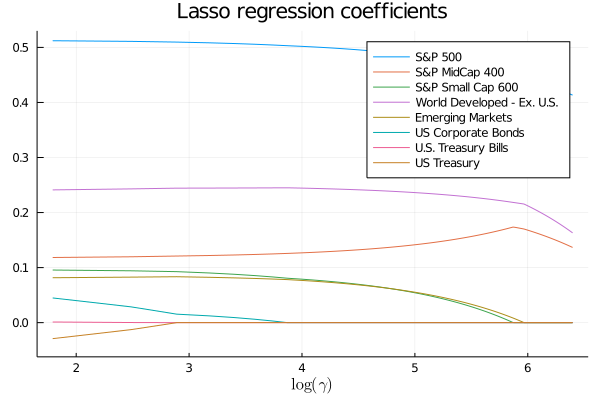

In [7]:
plot( log.(γM),bLasso',
      title = "Lasso regression coefficients",
      xlabel = L"\log(\gamma)",
      label = permutedims(IndNames),
      size = (600,400) )

# Ridge Regression

minimizes $(Y-Xb)'(Y-Xb) + \lambda \sum b_i^2$. We compare analytical and numerical results

In [8]:
RidgeRegression(Y,X,λ) = inv(X'X+λ*I)*X'Y


b_LS     = X\Y
b_ridge  = RidgeRegression(Y,X,100)
b_ridge2, = LassoEN(Y,X,0,100)

printmat([b_ls b_ridge b_ridge2])

     0.513     0.378     0.380
     0.117     0.190     0.190
     0.097     0.128     0.127
     0.239     0.230     0.230
     0.080     0.101     0.101
     0.061     0.049     0.049
     0.002     0.003     0.003
    -0.045    -0.037    -0.037



In [9]:
nλ = 101
λM = range(0,10000,length=nλ)

bridge   = fill(NaN,size(X,2),nλ)         
for i = 1:nλ
    bridge[:,i] = RidgeRegression(Y,X,λM[i])
end

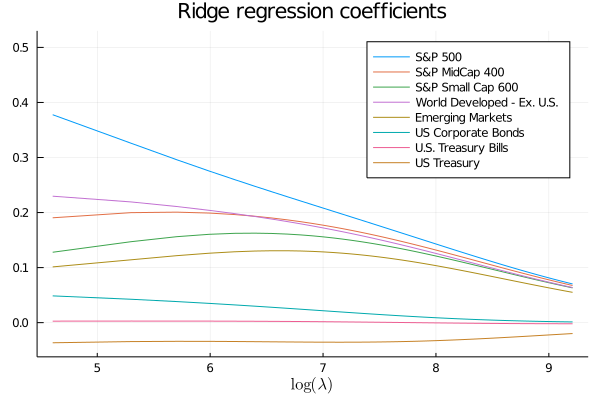

In [10]:
plot( log.(λM),bridge',
      title = "Ridge regression coefficients",
      xlabel = L"\log(\lambda)",
      label = permutedims(IndNames),
      size = (600,400) )

# Elastic Net Regression

minimizes a combination of the Lasso and Ridge regression loss functions

minimizes $(Y-Xb)'(Y-Xb) + \gamma \sum |b_i| + \lambda \sum b_i^2$.

In [11]:
λ = 200
println("redo the Lasso regression, but with λ=$λ")

bEN   = fill(NaN,size(X,2),nγ)         
for i = 1:nγ
    (bEN[:,i],_) = LassoEN(Y,X,γM[i],λ)
end

redo the Lasso regression, but with λ=200


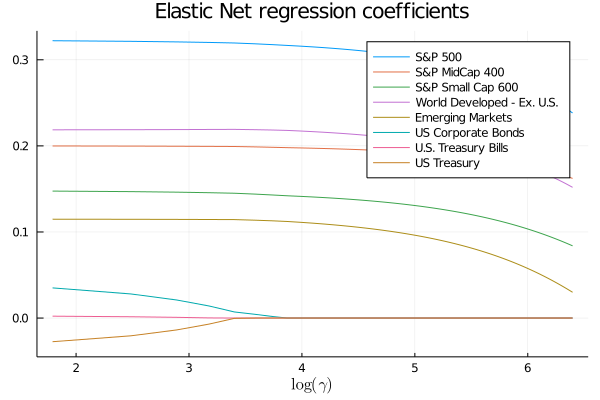

In [12]:
plot( log.(γM),bEN',
      title = "Elastic Net regression coefficients",
      xlabel = L"\log(\gamma)",
      label = permutedims(IndNames),
      size = (600,400) )